In [ ]:
import numpy as np
from numpy import linalg as la
from numpy.random import randn
import math 
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy.misc import derivative
import matplotlib.pyplot as plt
import random
import sympy as sym
import cmath
%matplotlib inline

# Introduction

<h1><center>

---



This is a bifurcation analysis of the Hodgkin Huxley model, which is a mathematical model that describes how action potentials in neurons are initiated and propagated. The model is composed of four main variables, which are $ V_m $ (membrane potential), $ n $ (potassium channel gating variable), $m$ (sodium channel gating variable associated with activation), and $h$ (sodium channel gating variable associated with inactivation). The system of DEs comprising the model is as follows:


$$ dV_m/dt = \displaystyle\frac{{\bar{g_K}}(n^4)(V_K - V_m) + {\bar{g_{Na}}}(m^3)h(V_{Na} - V_m) + {\bar{g_l}}(V_l - V_m) + I_{app}(t))}{C_m}$$

\\



$$ dn/dt = \alpha_n(V_m)(1 - n) - \beta_n(V_m)n $$
</center></h1>
$(1)$
<h1><center>

$$  dm/dt = \alpha_m(V_m)(1 - m) - \beta_m(V_m)m$$

\\

$$  dh/dt = \alpha_h(V_m)(1 - h) - \beta_h(V_m)h$$

where $\alpha_i$ and $\beta_i$ are the rate constants for opening and closing of the $i-th$ gating variable, described as:

$$ \alpha_n = \frac{0.01(V_m + 55)}{1 - e^{-(V_m + 55)/10}} ,  \alpha_m = \frac{0.1(V_m +40)}{1 - e^{-(V_m + 40)/10)}} ,  \alpha_h = 0.07e^{-(V_m+65)/20} $$

and

$$ \beta_n = 0.125e^{-(V_m + 65)/80},  \beta_m = 4e^{-(V_m + 65)/18},  \beta_h = \frac{1}{1 + e^{-(V_m+35)/10}}$$


---

</center></h1>


In [ ]:
#### Defining parameter values and rate constant equations



#potassium conductance(mS/cm^2)
gK = 36

#sodium conductance(mS/cm^2)
gNa = 120

#leak conductance(mS/cm^2)
gL = 0.3

# Membrane capacitance(uF/cm^2)
Cm = 1

# Potassium potential(mV)
VK = -82

# Sodium potential(mV)
VNa = 45

# Leak potential(mV)
Vl = -60




def alpha_n(Vm):
    return 0.01*(Vm + 55)/(1 - math.exp(-(Vm + 55)/10))

def beta_n(Vm):
    return 0.125*math.exp(-(Vm + 65)/80)

def alpha_m(Vm):
    return 0.1*(Vm+40)/(1 - math.exp(-(Vm + 40)/10))

def beta_m(Vm):
    return 4*math.exp(-(Vm + 65)/18)

def alpha_h(Vm):
    return 0.07*math.exp(-(Vm+65)/20)

def beta_h(Vm):
    return 1/(1 + math.exp(-(Vm+35)/10))


### Defining the derivatives of rate equations for the jacobian of the system


def an_dev(V):
  return derivative(alpha_n, V)

def bn_dev(V):
  return derivative(beta_n, V)

def am_dev(V):
  return derivative(alpha_m, V)

def bm_dev(V):
  return derivative(beta_m, V)

def ah_dev(V):
  return derivative(alpha_h, V)

def bh_dev(V):
  return derivative(beta_h, V)


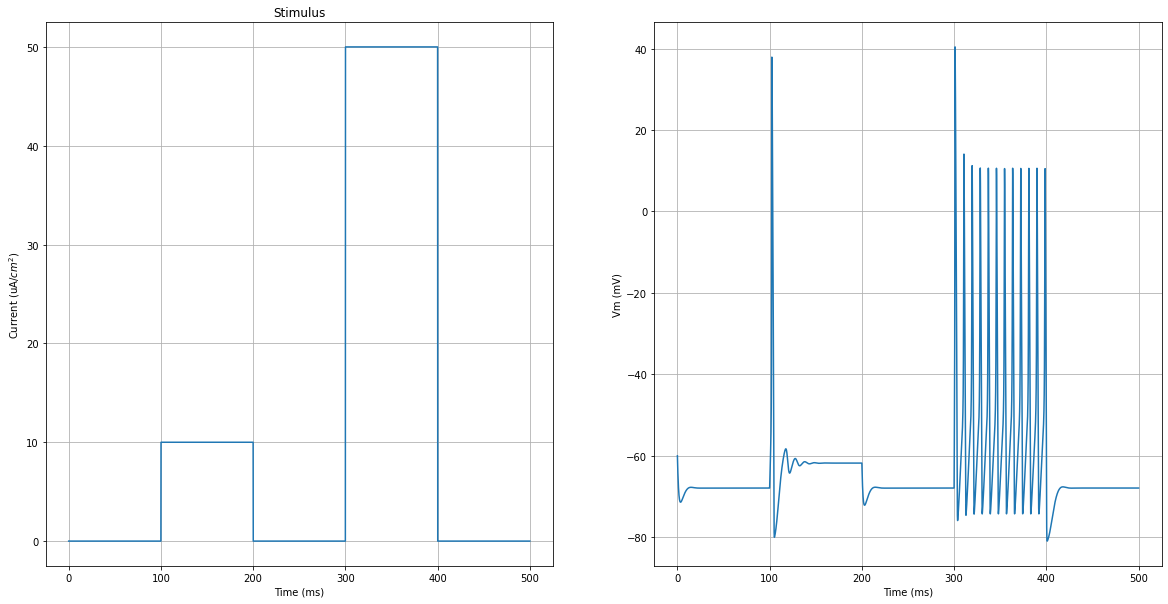

In [ ]:
### Test-run of the model, with the above parameters


T = np.linspace(0, 500, 10000)

# Input Current (uA/cm^2)
def I_app(t):
    if 100 < t < 200:
        return 10
    if 300 < t < 400:
        return 50
    return 0

def eqs(y,t):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    dy[0] = (gK*(n**4)*(VK - Vm) + gNa*(m**3)*h*(VNa - Vm) + gL*(Vl - Vm) + I_app(t))/Cm
    
    # dn/dt
    dy[1] = (alpha_n(Vm)*(1 - n)) - (beta_n(Vm)*n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm)*(1 - m)) - (beta_m(Vm)*m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm)*(1 - h)) - (beta_h(Vm)*h)
    
    return dy

Initial_val = np.array([Vl, 0.35, 0.05, 0.5])

V = odeint(eqs, Initial_val, T)

I = [I_app(t) for t in T]

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.plot(T, I)
plt.xlabel('Time (ms)')
plt.ylabel('Current (uA/$cm^2$)')
plt.title('Stimulus')
plt.grid()

plt.subplot(122)
plt.plot(T, V[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.grid()

In [ ]:
print(np.shape(V))

(10000, 4)


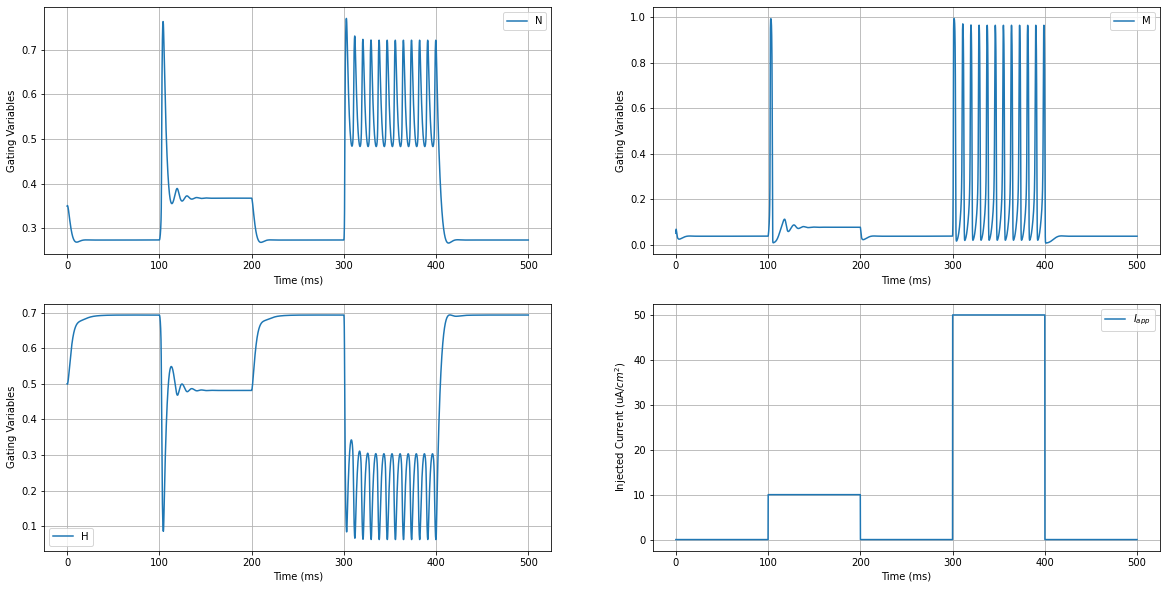

In [ ]:
### Observing gating variable dynamics with applied curent


plt.figure(figsize=(20, 10))

plt.subplot(221)
plt.plot(T, V[:, 1], label = 'N')
plt.xlabel('Time (ms)')
plt.ylabel('Gating Variables')
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(T, V[:, 2], label = 'M')
plt.xlabel('Time (ms)')
plt.ylabel('Gating Variables')
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(T, I, label = '$I_{app}$')
plt.xlabel('Time (ms)')
plt.ylabel('Injected Current (uA/$cm^2$)')
plt.legend()
plt.grid()

plt.subplot(223)
plt.plot(T, V[:, 3], label = 'H')
plt.xlabel('Time (ms)')
plt.ylabel('Gating Variables')
plt.legend()
plt.grid()

In order to obtain the equilibrium points of this system, we need to find the steady state solution of the system, and obtain the Jacobian to analyse the type of fixed point(s) reached. At the steady state (and keeping $I_{app} = 0$):

$$ \displaystyle\frac{{\bar{g_K}}(n^4)(V_K - V^\ast_m) + {\bar{g_{Na}}}(m^3)h(V_{Na} - V^\ast_m) + {\bar{g_l}}(V_l - V^\ast_m) + I_{app}(t))}{C_m} = 0$$

\\

$$ n^\ast = \frac{\alpha_n(V^\ast_m)}{\alpha_n(V^\ast_m) + \beta_n(V^\ast_m)}$$

$(2)$  

$$ m^\ast = \frac{\alpha_m(V^\ast_m)}{\alpha_m(V^\ast_m) + \beta_m(V^\ast_m)}$$

\\

$$ h^\ast = \frac{\alpha_h(V^\ast_m)}{\alpha_h(V^\ast_m) + \beta_h(V^\ast_m)} $$

\\

This gives us the Jacobian:

$$
\begin{bmatrix}
    \displaystyle\frac{-{\bar{g_K}}n^4 - {\bar{g_{Na}}}m^3h - {\bar{g_l}}} {C_m}  & \displaystyle\frac{4{\bar{g_K}}n^3(V_K - V_m)}{C_m} & \displaystyle\frac{3{\bar{g_{Na}}}m^2h(V_{Na} - V_m)}{C_m} & \displaystyle\frac{{\bar{g_{Na}}}(m^3)(V_{Na} - V_m)}{C_m} \\
    \alpha'_n(1-n) - \beta'_nn & -\alpha_n - \beta_n  & 0 & 0 \\
    \alpha'_m(1-m) - \beta'_mm & 0 & -\alpha_m - \beta_m & 0 \\
    \alpha'_h(1-h) - \beta'_hh & 0 & 0 & -\alpha_h - \beta_h
\end{bmatrix}
$$

\\

where $\alpha'_n = \frac{d\alpha_n}{dV_m} $ at $V_m = V^\ast_m $

Here, $ V^\ast_m$, $n^\ast$, $m^\ast$, and $h^\ast$ are the steady state solutions for each of the variables respectively.


In [ ]:

# The system as a function of vector (Vm, n, m, h)
def system(vec):
  Vm = vec[0]
  n = vec[1]
  m = vec[2]
  h = vec[3]
  
  L1 = (gK*(n**4)*(VK - Vm) + gNa*(m**3)*h*(VNa - Vm) + gL*(Vl - Vm))/Cm
  L2 = (alpha_n(Vm)*(1 - n)) - (beta_n(Vm)*n)
  L3 = (alpha_m(Vm)*(1 - m)) - (beta_m(Vm)*m)
  L4 = (alpha_h(Vm)*(1 - h)) - (beta_h(Vm)*h)

  return (L1, L2, L3, L4)

### The jacobian for this system, with the same input vector
def jac(vec):
  Vm = vec[0]
  n = vec[1]
  m = vec[2]
  h = vec[3]
  
  J_11 = ( -gK*(n**4) - gNa*(m**3)*h - gL )/Cm
  J_12 = ( 4*gK*(n**3)*(VK - Vm) )/Cm
  J_13 = ( 3*gNa*(m**2)*h*(VNa - Vm) )/Cm
  J_14 = ( gNa*(m**3)*(VNa - Vm) )/Cm

  J_21 = (an_dev(Vm)*(1 - n)) - (bn_dev(Vm)*n)
  J_22 = - alpha_n(Vm) - beta_n(Vm)

  J_31 = (am_dev(Vm)*(1 - m)) - (bm_dev(Vm)*m)
  J_33 = - alpha_m(Vm) - beta_m(Vm)


  J_41 = (ah_dev(Vm)*(1 - h)) - (bh_dev(Vm)*h)
  J_44 = - alpha_h(Vm) - beta_h(Vm)

  return np.array( [ (J_11, J_12, J_13, J_14), (J_21, J_22, 0, 0), (J_31, 0, J_33, 0), (J_41, 0, 0, J_44) ] )

def is_between(x, y, p):
  if x > p and y < p and x > y:
    return True
  elif x < p and y > p and x < y:
    return True
  return False


For the given parameter values, we can solve this system of equations, and obtain the jacobian and eigenvalues: 

In [ ]:
sol = root(system, [1, 1, 1, 1])
jacobian = jac(sol.x)
print(jacobian)

[[-5.07582648e-01 -4.17776613e+01  3.92681889e+01  7.05128893e-01]
 [ 2.59363176e-03 -1.78592701e-01  0.00000000e+00  0.00000000e+00]
 [ 2.21817153e-02  0.00000000e+00 -4.88539454e+00  0.00000000e+00]
 [-3.64309769e-03  0.00000000e+00  0.00000000e+00 -1.16847021e-01]]


In [ ]:
eigens = la.eigvals(jacobian)
print(eigens)

[-5.07515367+0.j        -0.24756555+0.3187685j -0.24756555-0.3187685j
 -0.11813215+0.j       ]


# Bifurcation Diagrams for various parameters



---
A bifurcation occurs in a system when a smooth change in the value of a parameter $\lambda$ causes a sudden qualitative change in the system's behaviour.

To observe if a bifurcation occurs in this system, we can plot a bifurcation diagram, which is a diagram of the parameter in question vs the steady state of the system, and look for any abrupt loss of continuity which might indicate a qualtiitve change in the system's behaviour. 

In our system, any constant term can qualify as a parameter, but not all will show any bifurcations inside the chosen range of values.

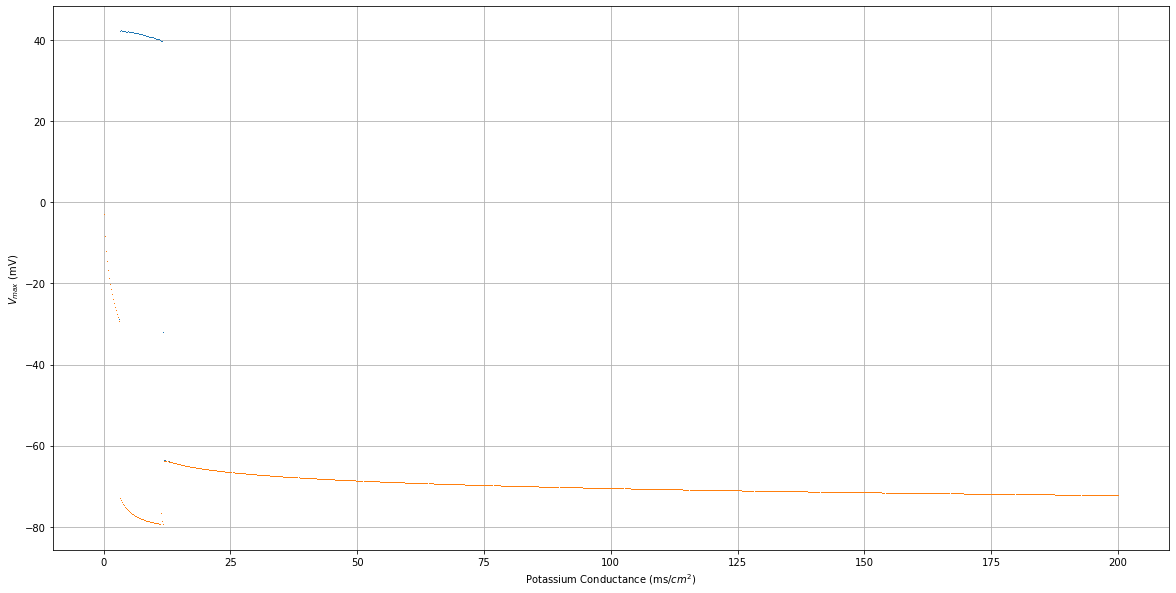

In [ ]:
#### Taking Potassium Conductance as a parameter.
#### Since physiologically observed value for gK is 36 mS/cm^2, we will consider a range of (0, 200) to check for any bifurcations.

gk = np.linspace(0, 200, 1000) 

T = np.linspace(0, 100, 1000)
T_list = T.tolist()
V_ss = []

def eqs(y,t):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    dy[0] = (gK*(n**4)*(VK - Vm) + gNa*(m**3)*h*(VNa - Vm) + gL*(Vl - Vm) + I_app(t))/Cm
    
    # dn/dt
    dy[1] = (alpha_n(Vm)*(1 - n)) - (beta_n(Vm)*n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm)*(1 - m)) - (beta_m(Vm)*m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm)*(1 - h)) - (beta_h(Vm)*h)
    
    return dy

Initial_val = np.array([0, 0, 0, 0])

for i in gk:
    
    gK = i
    
    V = odeint(eqs, Initial_val, T)
    
    # Measuring steady potential peak and min values
    V_window = V[:, 0][800: ]
    V_steady = np.max(V_window)
    V_low = np.min(V_window)
 
    V_ss.append((i, V_steady, V_low))
    
x = []
y = []
z = []
for j in V_ss:
    x.append(j[0])
    y.append(j[1])
    z.append(j[2])

plt.figure(figsize=(20, 10))

plt.plot(x, y, ls = '', marker = ',')
plt.plot(x, z, ls = '', marker = ',')
plt.xlabel('Potassium Conductance (ms/$cm^2$)')
plt.ylabel('$V_{max}$ (mV)')
plt.grid()



---

There appears to be a sudden burst of firing activity somewhere inside the range $g_{K} \epsilon (0, 25)$ and then a stable steady state everywhere else. This indicates 2 bifurcation points somewhere between 0 and 25, which can be calculated by observing the values of $g_K$ where the eigenvalues of the jacobian cross the imaginary axis of the complex plane, i.e the real component changes sign. 


---



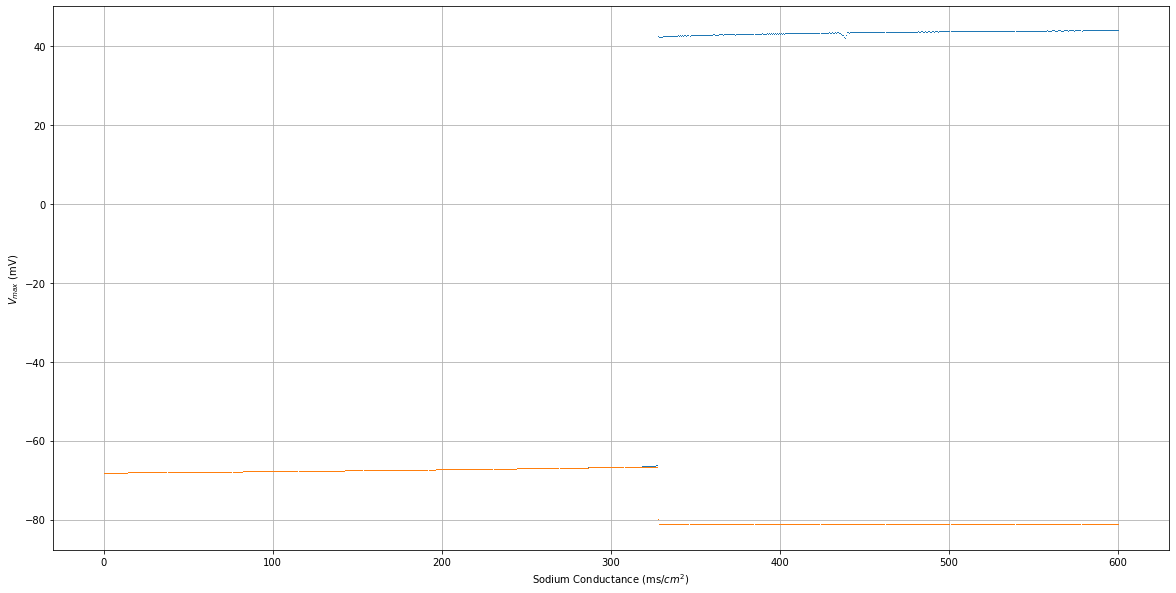

In [ ]:
#### Taking Sodium Conductance as a parameter.
#### Since physiologically observed value for gNa is 120 mS/cm^2, we will consider a range of (0, 600) to check for any bifurcations.
gK = 36

gna = np.linspace(0, 600, 1000) 

T = np.linspace(0, 100, 1000)
T_list = T.tolist()
V_ss = []

def eqs(y,t):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    dy[0] = (gK*(n**4)*(VK - Vm) + gNa*(m**3)*h*(VNa - Vm) + gL*(Vl - Vm))/Cm 
    
    # dn/dt
    dy[1] = (alpha_n(Vm)*(1 - n)) - (beta_n(Vm)*n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm)*(1 - m)) - (beta_m(Vm)*m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm)*(1 - h)) - (beta_h(Vm)*h)
    
    return dy

Initial_val = np.array([0, 0, 0, 0])
    
for i in gna:
    
    gNa = i
    
    V = odeint(eqs, Initial_val, T)
    
    # Measuring steady potential peak and min values
    V_window = V[:, 0][800: ]
    V_steady = np.max(V_window)
    V_low = np.min(V_window)
 
    V_ss.append((i, V_steady, V_low))
    
x = []
y = []
z = []
for j in V_ss:
    x.append(j[0])
    y.append(j[1])
    z.append(j[2])

plt.figure(figsize=(20, 10))

plt.plot(x, y, ls = '', marker = ',')
plt.plot(x, z, ls = '', marker = ',')
plt.xlabel('Sodium Conductance (ms/$cm^2$)')
plt.ylabel('$V_{max}$ (mV)')
plt.grid()

---

Similar to the previous diagram, here appears to be a sudden burst of firing activity somewhere inside the range $g_{Na} \epsilon (300, 400)$, but this time the firing behaviour is seen till the highest parameter value. This indicates a single bifurcation point somewhere between 300 and 400, which can again be calculated by observing the values of $g_{Na}$ where the real components of the eigenvalues change signs. 


---

-60


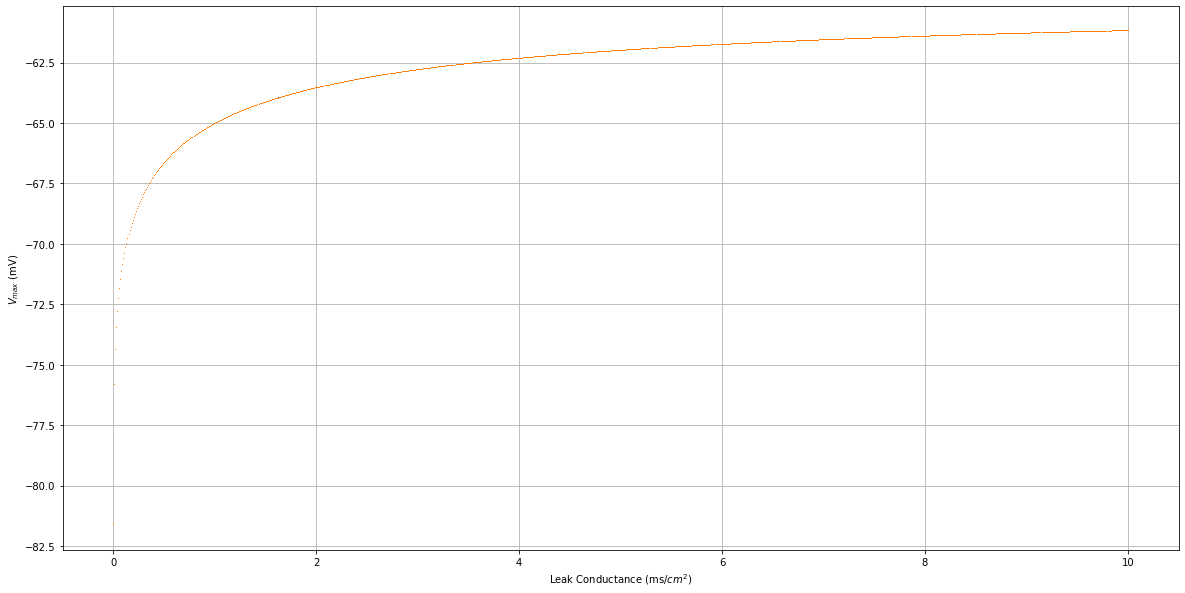

In [ ]:
#### Taking Leak Conductance as a parameter.
#### Since physiologically observed value for gL is 0.3 mS/cm^2, we will consider a range of (0, 10) to check for any bifurcations.

gK = 36
gNa = 120

gl = np.linspace(0, 10, 1000) 

T = np.linspace(0, 100, 1000)
T_list = T.tolist()
V_ss = []

def eqs(y,t):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    dy[0] = (gK*(n**4)*(VK - Vm) + gNa*(m**3)*h*(VNa - Vm) + gL*(Vl - Vm))/Cm 
    
    # dn/dt
    dy[1] = (alpha_n(Vm)*(1 - n)) - (beta_n(Vm)*n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm)*(1 - m)) - (beta_m(Vm)*m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm)*(1 - h)) - (beta_h(Vm)*h)
    
    return dy

Initial_val = np.array([0, 0, 0, 0])
    
for i in gl:
    
    gL = i
    
    V = odeint(eqs, Initial_val, T)
    
    # Measuring steady potential peak and min values
    V_window = V[:, 0][800: ]
    V_steady = np.max(V_window)
    V_low = np.min(V_window)
 
    V_ss.append((i, V_steady, V_low))
    
x = []
y = []
z = []
for j in V_ss:
    x.append(j[0])
    y.append(j[1])
    z.append(j[2])

plt.figure(figsize=(20, 10))

plt.plot(x, y, ls = '', marker = ',')
plt.plot(x, z, ls = '', marker = ',')
plt.xlabel('Leak Conductance (ms/$cm^2$)')
plt.ylabel('$V_{max}$ (mV)')
plt.grid()

print(Vl)

The above plot is smooth for $ g_L \epsilon (0, 10) $, which means there are no bifurcation points in that range for this parameter.


---



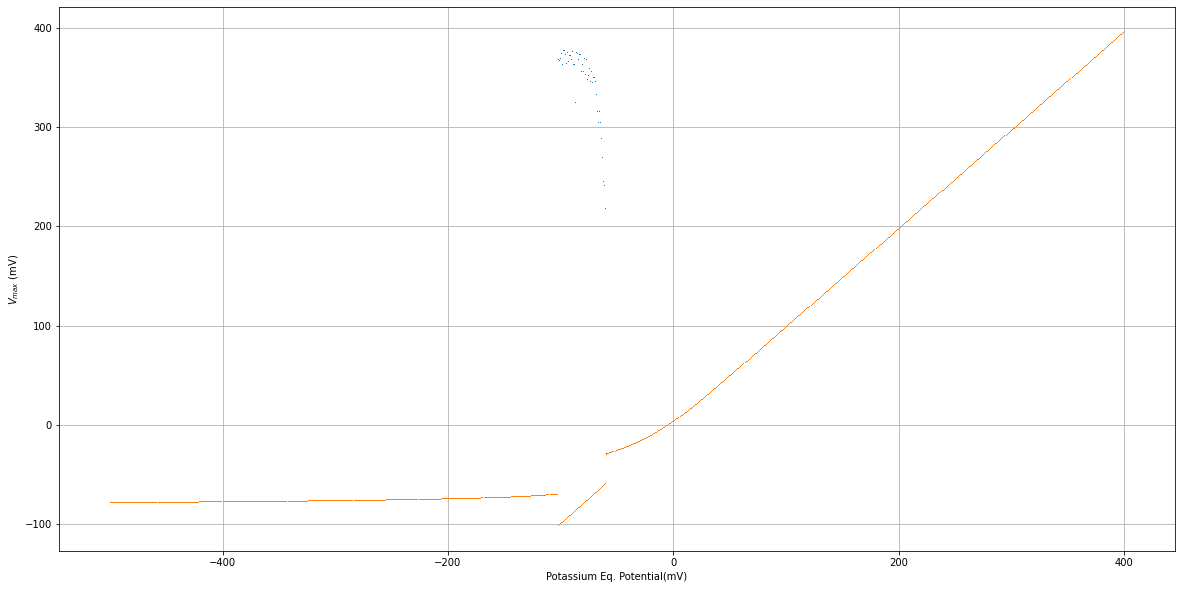

In [ ]:
### Plotting bifurcation diagram for potassium equilibrium potential vs membrane potential, in the range (-500, 400)

gK = 36
gNa = 120
gL = 0.3

vk = np.linspace(-500, 400, 1000) 

T = np.linspace(0, 100, 1000)
T_list = T.tolist()
V_ss = []

def eqs(y,t):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    dy[0] = (gK*(n**4)*(VK - Vm) + gNa*(m**3)*h*(VNa - Vm) + gL*(Vl - Vm))/Cm 
    
    # dn/dt
    dy[1] = (alpha_n(Vm)*(1 - n)) - (beta_n(Vm)*n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm)*(1 - m)) - (beta_m(Vm)*m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm)*(1 - h)) - (beta_h(Vm)*h)
    
    return dy

Initial_val = np.array([0, 0, 0, 0])
    
for i in vk:
    
    VK = i
    
    V = odeint(eqs, Initial_val, T)
    
    # Measuring steady potential peak and min values
    V_window = V[:, 0][800: ]
    V_steady = np.max(V_window)
    V_low = np.min(V_window)
 
    V_ss.append((i, V_steady, V_low))
    
x = []
y = []
z = []
for j in V_ss:
    x.append(j[0])
    y.append(j[1])
    z.append(j[2])

plt.figure(figsize=(20, 10))

plt.plot(x, y, ls = '', marker = ',')
plt.plot(x, z, ls = '', marker = ',')
plt.xlabel('Potassium Eq. Potential(mV)')
plt.ylabel('$V_{max}$ (mV)')
plt.grid()

Just like the case when $g_K$ was the parameter, we see two bifurcation points in $ V_K \epsilon (-200, 0) $. However this time the range seems considerable narrower, and the decay in firing activity appears to be quicker.

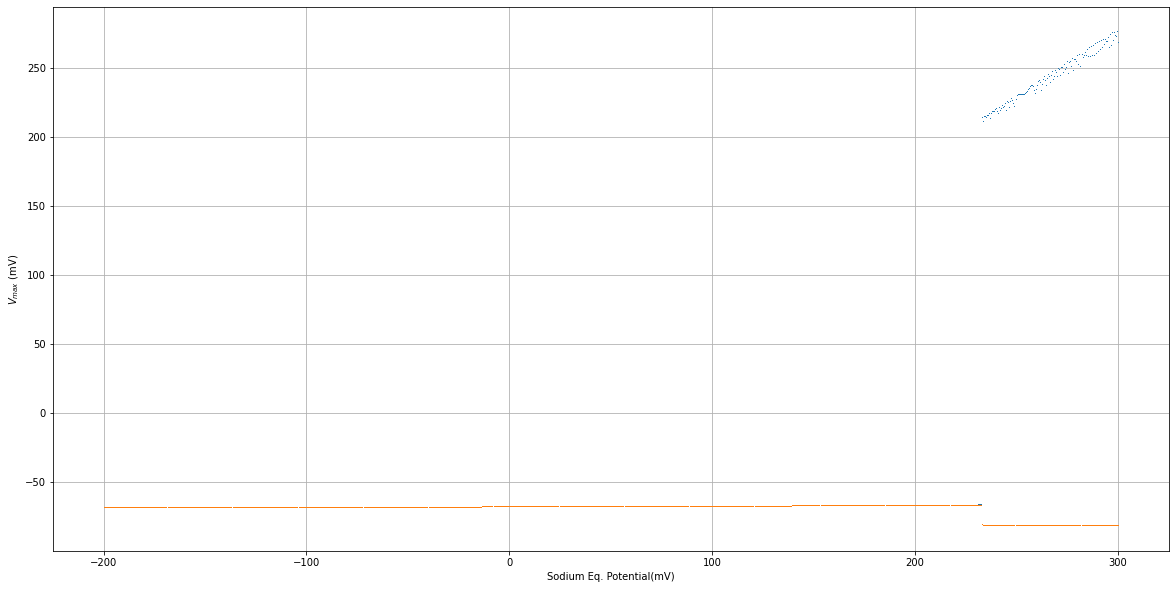

In [ ]:
### Plotting bifurcation diagram for sodium equilibrium potential vs membrane potential, in the range (-200, 300)

gK = 36
gNa = 120
gL = 0.3
VK = -82
vna = np.linspace(-200, 300, 1000) 

T = np.linspace(0, 100, 1000)
T_list = T.tolist()
V_ss = []

def eqs(y,t):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    dy[0] = (gK*(n**4)*(VK - Vm) + gNa*(m**3)*h*(VNa - Vm) + gL*(Vl - Vm))/Cm 
    
    # dn/dt
    dy[1] = (alpha_n(Vm)*(1 - n)) - (beta_n(Vm)*n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm)*(1 - m)) - (beta_m(Vm)*m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm)*(1 - h)) - (beta_h(Vm)*h)
    
    return dy

Initial_val = np.array([0, 0, 0, 0])
    
for i in vna:
    
    VNa = i
    
    V = odeint(eqs, Initial_val, T)
    
    # Measuring steady potential peak and min values
    V_window = V[:, 0][800: ]
    V_steady = np.max(V_window)
    V_low = np.min(V_window)
 
    V_ss.append((i, V_steady, V_low))
    
x = []
y = []
z = []
for j in V_ss:
    x.append(j[0])
    y.append(j[1])
    z.append(j[2])

plt.figure(figsize=(20, 10))

plt.plot(x, y, ls = '', marker = ',')
plt.plot(x, z, ls = '', marker = ',')
plt.xlabel('Sodium Eq. Potential(mV)')
plt.ylabel('$V_{max}$ (mV)')
plt.grid()

From the diagram above, there appears to be a single bifurcation point in the range $ V_{Na} \epsilon (200, 300), with behaviour transitioning from steady potential levels to constant firing activity.


---

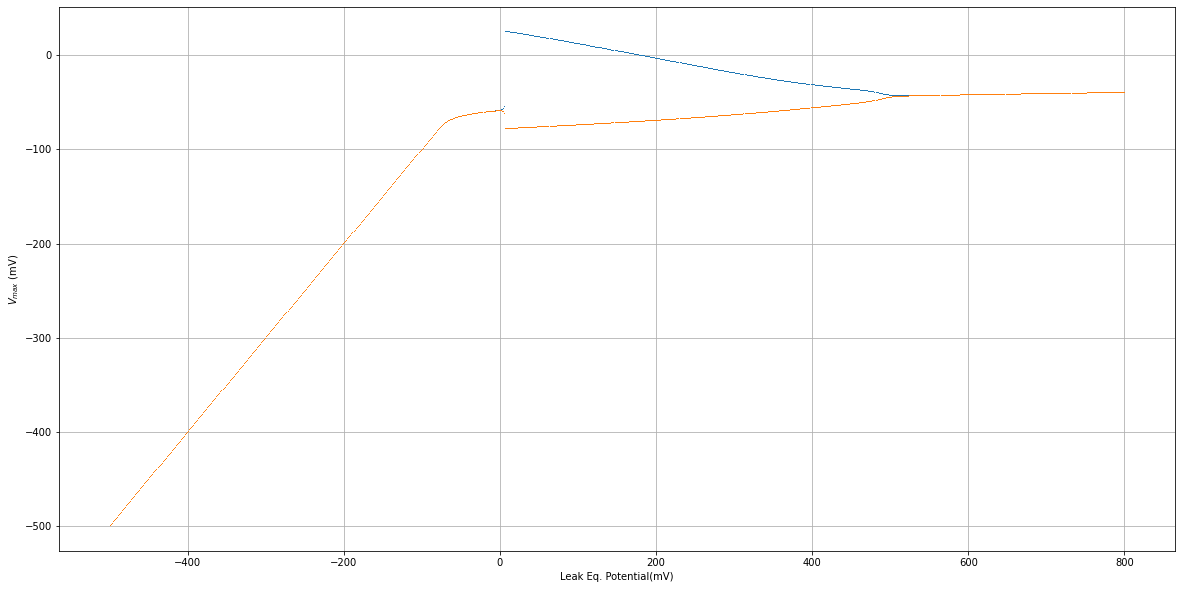

In [ ]:
### Plotting bifurcation diagram for leak equilibrium potential vs membrane potential, in the range (-500, 400)

gK = 36
gNa = 120
gL = 0.3
VK = -82
VNa = 45
vl = np.linspace(-500, 800, 1000) 

T = np.linspace(0, 100, 1000)
T_list = T.tolist()
V_ss = []

def eqs(y,t):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    dy[0] = (gK*(n**4)*(VK - Vm) + gNa*(m**3)*h*(VNa - Vm) + gL*(Vl - Vm))/Cm 
    
    # dn/dt
    dy[1] = (alpha_n(Vm)*(1 - n)) - (beta_n(Vm)*n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm)*(1 - m)) - (beta_m(Vm)*m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm)*(1 - h)) - (beta_h(Vm)*h)
    
    return dy

Initial_val = np.array([0, 0, 0, 0])
    
for i in vl:
    
    Vl = i
    
    V = odeint(eqs, Initial_val, T)
    
    # Measuring steady potential peak and min values
    V_window = V[:, 0][800: ]
    V_steady = np.max(V_window)
    V_low = np.min(V_window)
 
    V_ss.append((i, V_steady, V_low))
    
x = []
y = []
z = []
for j in V_ss:
    x.append(j[0])
    y.append(j[1])
    z.append(j[2])

plt.figure(figsize=(20, 10))

plt.plot(x, y, ls = '', marker = ',')
plt.plot(x, z, ls = '', marker = ',')
plt.xlabel('Leak Eq. Potential(mV)')
plt.ylabel('$V_{max}$ (mV)')
plt.grid()

Here there are two bifurcation points, in the range $ V_l \epsilon (0, 600) $

# Bifurcation points for $g_K$ as a parameter





---

Now that we know what parameters show a bifurcation or two along with the range of values in which they occur, we can start calculating them with more accuracy.

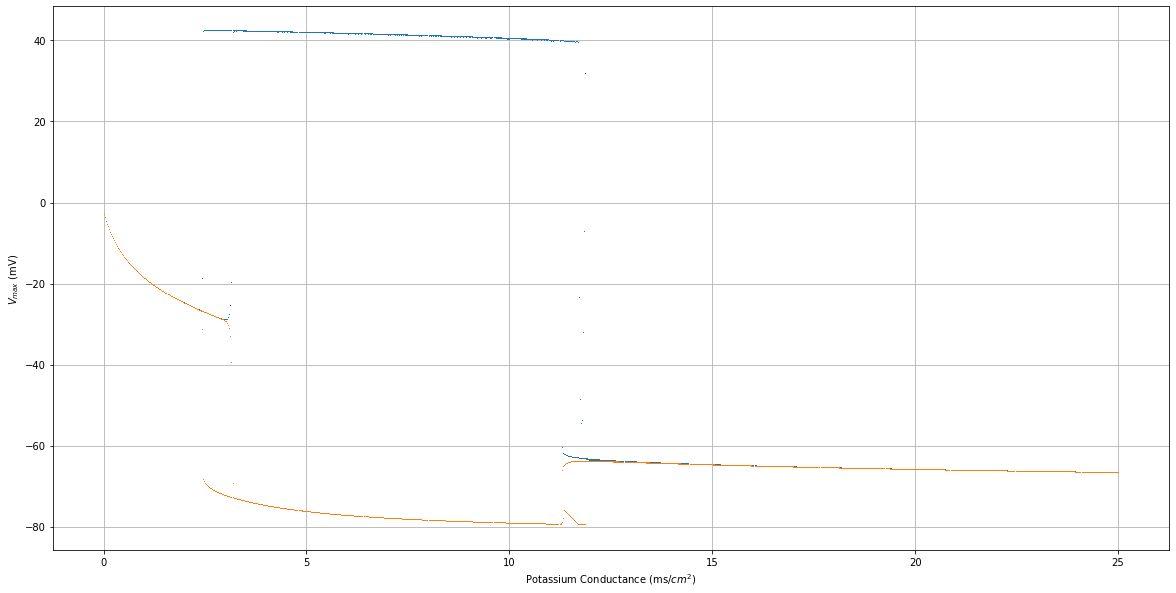

In [ ]:
### Bifurcation Points for gK

gk = np.linspace(0, 25, 1000)                  ## From the bifurcation diagram we can narrow down the range in which the bifurcations occur
gNa = 120
gL = 0.3
VK = -82
VNa = 45
Vl = -60

### Another bifurcation diagram to narrow down the range even more

T = np.linspace(0, 100, 1000)
T_list = T.tolist()
V_ss = []

Initial_val = np.array([0, 0, 0, 0])

for i in gk:
    
    gK = i
    
    V = odeint(eqs, Initial_val, T)
    
    # Measuring steady potential peak and min values
    V_window = V[:, 0][800: ]
    V_steady = np.max(V_window)
    V_low = np.min(V_window)
 
    V_ss.append((i, V_steady, V_low))
    
x = []
y = []
z = []
for j in V_ss:
    x.append(j[0])
    y.append(j[1])
    z.append(j[2])

plt.figure(figsize=(20, 10))

plt.plot(x, y, ls = '', marker = ',')
plt.plot(x, z, ls = '', marker = ',')
plt.xlabel('Potassium Conductance (ms/$cm^2$)')
plt.ylabel('$V_{max}$ (mV)')
plt.grid()


In [ ]:
eig_vals0 = []                                 # Lists for storing the 4 eigenvalues for each value of gK
eig_vals1 = []
eig_vals2 = []
eig_vals3 = []

gk = np.linspace(2, 3.5, 1000)
gNa = 120
gL = 0.3
VK = -82
VNa = 45
Vl = -60

for i in gk:
  gK = i
  steady_state = root(system, [1, 1, 1, 1], jac = jac)
  jacobian = jac(steady_state.x)
  eigens = la.eigvals(jacobian).real
  eig_vals0.append(eigens[0])
  eig_vals1.append(eigens[1])
  eig_vals2.append(eigens[2])
  eig_vals3.append(eigens[3])

bif_points0  = []
bif_points1  = []
bif_points2  = []
bif_points3  = []

for i in range(len(gk) - 1):
  if is_between(eig_vals0[i], eig_vals0[i + 1], 0) ==  True and (gk[i], gk[i + 1]) not in bif_points0:
    bif_points0.append((gk[i], gk[i + 1]))

  if is_between(eig_vals1[i], eig_vals1[i + 1], 0) ==  True and (gk[i], gk[i + 1]) not in bif_points1:
    bif_points1.append((gk[i], gk[i + 1]))

  if is_between(eig_vals2[i], eig_vals2[i + 1], 0) ==  True and (gk[i], gk[i + 1]) not in bif_points2:
    bif_points2.append((gk[i], gk[i + 1]))

  if is_between(eig_vals3[i], eig_vals3[i + 1], 0) ==  True and (gk[i], gk[i + 1]) not in bif_points3:
    bif_points3.append((gk[i], gk[i + 1]))

print(bif_points0)
print(bif_points1)
print(bif_points2)
print(bif_points3)

[]
[(3.069069069069069, 3.0705705705705704)]
[(3.069069069069069, 3.0705705705705704)]
[]


From the bifurcation diagram, we can narrow down the range of the bifurcation points to $ g_{K1} \epsilon (3.053053053, 3.078078078) $ and $ g_{K1} \epsilon (11.161161161, 11.786786787) $. We see the change in firing behaviour before and after the points, by plotting the membrane potential vs time of the HH neuron at these 4 values of $g_K$

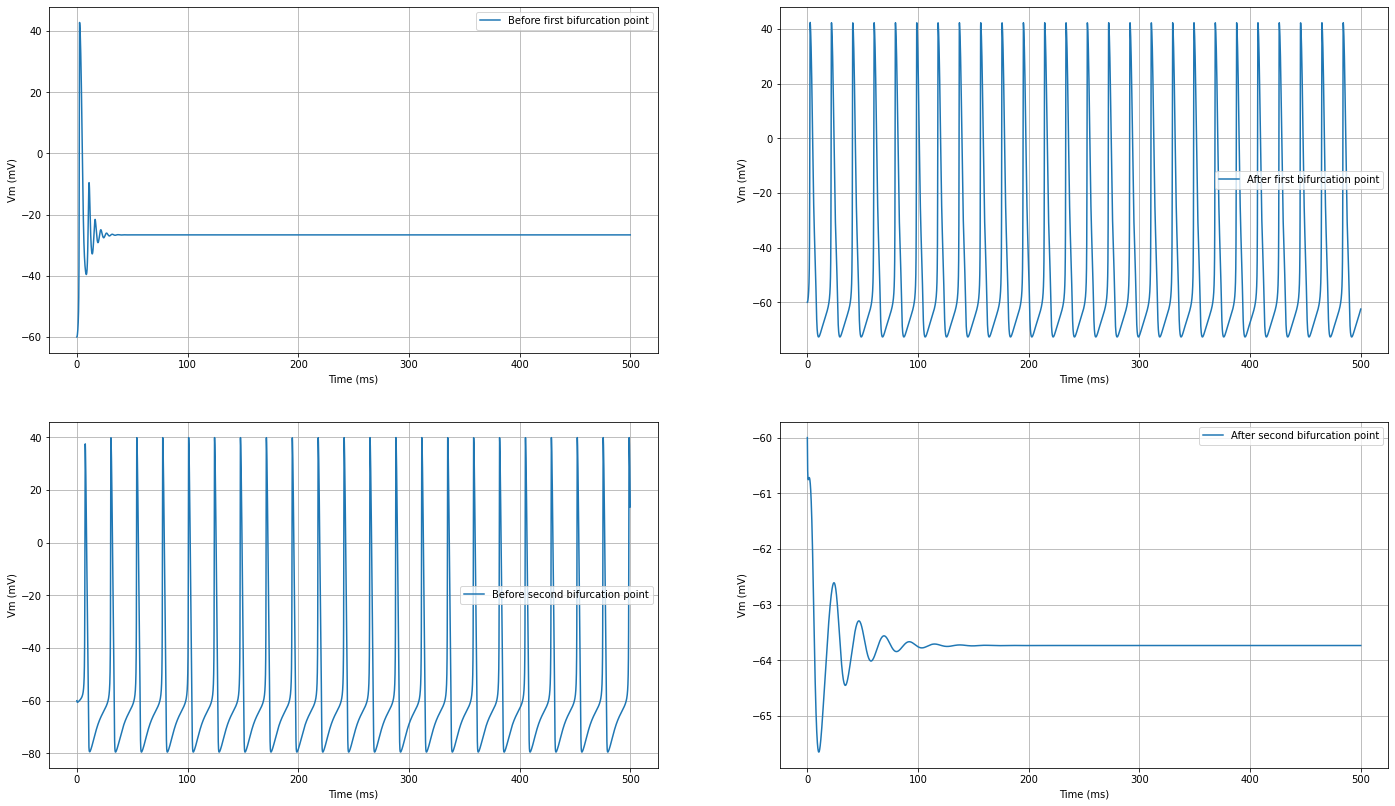

In [ ]:
#### Qualitiative change in firing pattern before and after the bifurcation points (3.053053053, 3.078078078, 11.161161161,11.786786787)

gk = (2.353053053, 3.078078078, 11.161161161,11.786786787)                       # The change in firing behaviour was observed only when the first value was reduced to 2.353053053)
gNa = 120
gL = 0.3
VK = -82
VNa = 45
Vl = -60
T = np.linspace(0, 500, 10000)

memb_pot = []

def eqs(y,t):
    dy = np.zeros((4,))

    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    dy[0] = (gK*(n**4)*(VK - Vm) + gNa*(m**3)*h*(VNa - Vm) + gL*(Vl - Vm))/Cm 
    
    # dn/dt
    dy[1] = (alpha_n(Vm)*(1 - n)) - (beta_n(Vm)*n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm)*(1 - m)) - (beta_m(Vm)*m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm)*(1 - h)) - (beta_h(Vm)*h)
    
    return dy

for i in gk:
  gK = i
  Initial_val = np.array([Vl, 0.35, 0.05, 0.5])
  V = odeint(eqs, Initial_val, T)
  memb_pot.append(V[:, 0])

plt.figure(figsize=(24, 14))

plt.subplot(221)
plt.plot(T, memb_pot[0], label = 'Before first bifurcation point')
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(T, memb_pot[1], label = 'After first bifurcation point')
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.legend()
plt.grid()

plt.subplot(223)
plt.plot(T, memb_pot[2], label = 'Before second bifurcation point')
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(T, memb_pot[3], label = 'After second bifurcation point')
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.legend()
plt.grid()



---

Now that we have narrowed down the range for the bifurcation points, we can narrow them down more precisely.


2.440383053
2.4403840530000003
2.4403850530000004
2.4403860530000006
2.4403870530000007
2.440388053000001
2.440389053000001
2.440390053000001
2.4403910530000013
2.4403920530000014


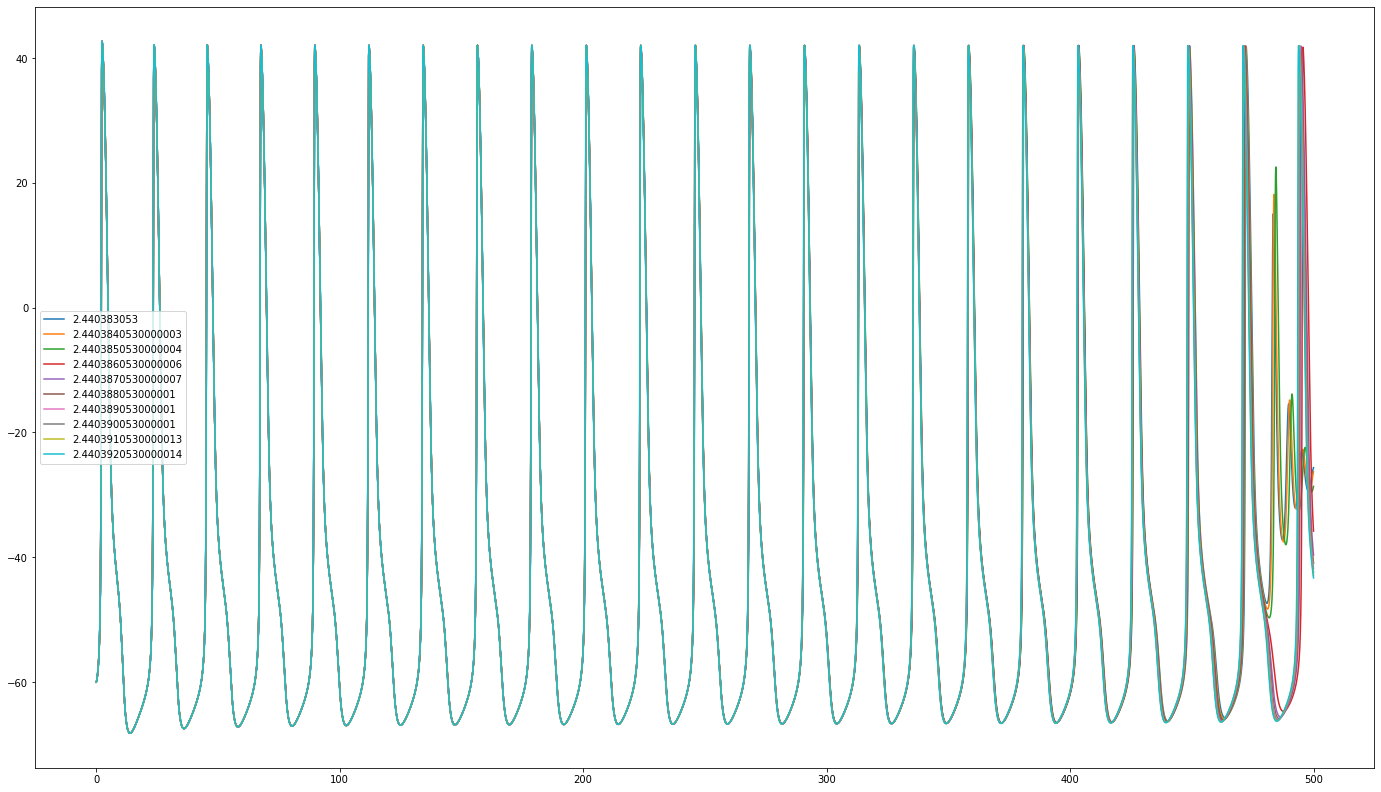

In [ ]:
#### Calculating the bifurcation points to the specified accuracy

dx = 10**(-6)   # Accuracy of our approximation

gNa = 120
gL = 0.3
VK = -82
VNa = 45
Vl = -60
T = np.linspace(0, 500, 10000)
gK = 2.440383053

plt.figure(figsize = (24, 14))

while gK < 2.440393053:
  Initial_val = np.array([Vl, 0.35, 0.05, 0.5])
  V = odeint(eqs, Initial_val, T)
  plt.plot(T, V[:, 0], label = gK)
  plt.legend()
  print(gK)
  gK += dx




---

From the above plot we can see that the first bifurcation occurs at $g_K$ approximately equal to 2.440385 $mS/cm^2$ 
Applying the same process we can calculate the other bifurcations points to within the desired accuracy.


---



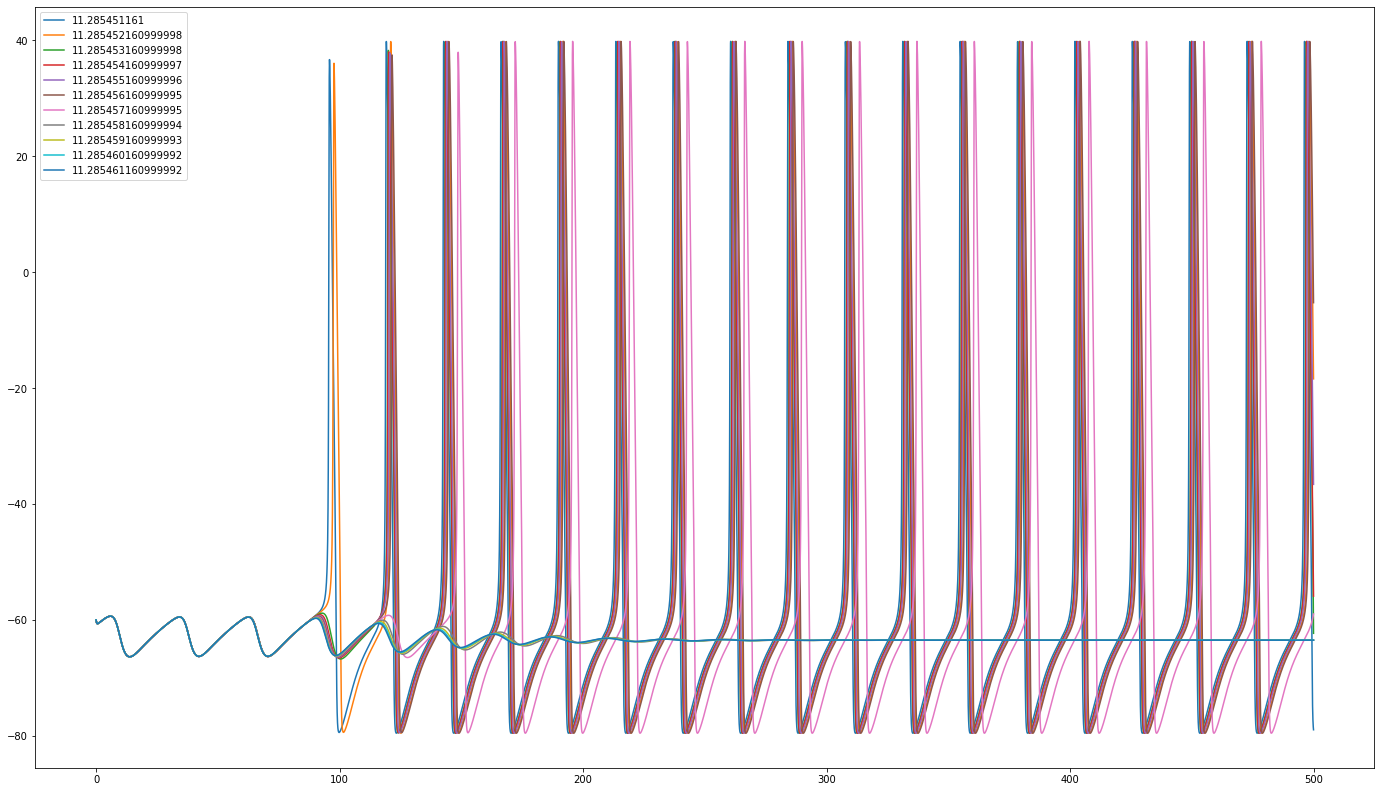

In [ ]:
### Approximating the second bifurcation point

dx = 10**(-6)   # Accuracy of our approximation

gNa = 120
gL = 0.3
VK = -82
VNa = 45
Vl = -60
T = np.linspace(0, 500, 10000)
gK = 11.285451161

plt.figure(figsize = (24, 14))

while gK < 11.285461161:
  Initial_val = np.array([Vl, 0.35, 0.05, 0.5])
  V = odeint(eqs, Initial_val, T)
  plt.plot(T, V[:, 0], label = gK)
  plt.legend()
  gK += dx

---
From the above plot we can see that the second bifurcation occurs at $g_K$ approximately equal to 11.285459 $mS/cm^2$ 

Hence inside the range $ g_K \epsilon (2.440385, 11.285459)$, the neuron shows rapid firing activity, and shows damped oscillations leading to a constant membrane potential outside.

Using the same method as above (calculating eigenvalues, and approximating the points to desired accuracy) we can narrow down the bifurcation points for each parameter.


---